In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"jaygupta7426","key":"e666150316507f6c72f878c586ae01e4"}'}

In [4]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
! unzip /content/utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

In [10]:
path = "/content/utkface_aligned_cropped/crop_part1"
images = []
age = []
gender = []
for img in os.listdir(path):
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  images.append(np.array(img))
  age.append(np.array(ages))
  gender.append(np.array(genders))
  
age = np.array(age,dtype=np.int64)
images = np.array(images)  #Forgot to scale image for my training. Please divide by 255 to scale. 
gender = np.array(gender,np.uint64)

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42)

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42)

In [11]:
#Define age model and train. 
##################################

age_model = Sequential()
age_model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(200,200,3)))
#age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))
              
age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Flatten())
age_model.add(Dropout(0.2))
age_model.add(Dense(512, activation='relu'))

age_model.add(Dense(1, activation='linear', name='age'))
              
age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(age_model.summary())              
                           
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_test_age, y_test_age), epochs=50)

age_model.save('age_model_50epochs.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 256)      0

In [12]:
#Define gender model and train
##################################################
gender_model = Sequential()

gender_model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(200,200,3)))

gender_model.add(MaxPool2D(pool_size=3, strides=2))
gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(256, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(512, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_test_gender, y_test_gender), epochs=50)

gender_model.save('gender_model_50epochs.h5')


Epoch 1/50
230/230 [==============================] - 16s 59ms/step - loss: 2.1858 - accuracy: 0.5978 - val_loss: 0.6284 - val_accuracy: 0.6290
Epoch 2/50
230/230 [==============================] - 13s 55ms/step - loss: 0.5914 - accuracy: 0.6810 - val_loss: 0.5990 - val_accuracy: 0.6888
Epoch 3/50
230/230 [==============================] - 13s 54ms/step - loss: 0.5606 - accuracy: 0.7118 - val_loss: 0.5181 - val_accuracy: 0.7297
Epoch 4/50
230/230 [==============================] - 13s 56ms/step - loss: 0.5281 - accuracy: 0.7275 - val_loss: 0.5022 - val_accuracy: 0.7403
Epoch 5/50
230/230 [==============================] - 13s 56ms/step - loss: 0.4975 - accuracy: 0.7517 - val_loss: 0.4733 - val_accuracy: 0.7648
Epoch 6/50
230/230 [==============================] - 12s 54ms/step - loss: 0.4777 - accuracy: 0.7588 - val_loss: 0.4827 - val_accuracy: 0.7640
Epoch 7/50
230/230 [==============================] - 12s 54ms/step - loss: 0.4607 - accuracy: 0.7736 - val_loss: 0.4740 - val_accuracy:

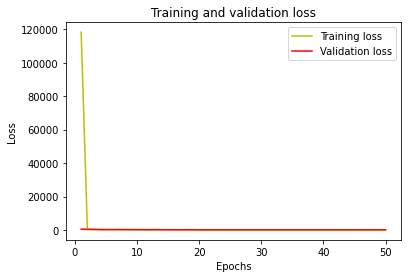

In [13]:
history = history_age

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
gender_model.metrics_names

['loss', 'accuracy']

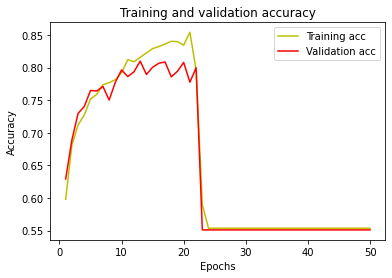

In [20]:
history = history_gender
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy =  0.550920245398773


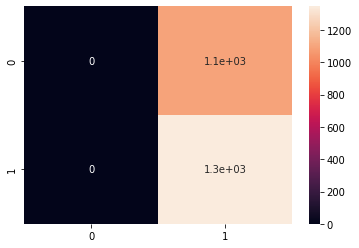

In [21]:
from keras.models import load_model
#Test the model
my_model = load_model('gender_model_50epochs.h5', compile=False)


predictions = my_model.predict(x_test_gender)
y_pred = (predictions>= 0.5).astype(int)[:,0]

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_gender, y_pred))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test_gender, y_pred)  
sns.heatmap(cm, annot=True)